# Modelos de Classificação: 3 Grupos
Vamos tentar uma abordagem de classificação para este problema. Para isso, lembramos que a qualidade do vinho é, na prática, uma variável categórica numérica que vai de 3 a 9 (vide histograma desta variável em analise_exploratoria.ipynb). Assim, diremos a princípio, com certa arbitrariedade, que existem vinhos ruins (3, 4, 5), médios (6) e bons (7, 8, 9). Então, tentaremos criar um modelo preditivo que, dadas as variáveis disponíveis, classifique o vinho dentro dessas opções.
Legenda:
- Ruim = 1
- Médio = 2
- Bom = 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def trata_dataframe(df):
    # Para eliminar o 3º tipo, contamos os pontos do valor em 'alcohol' e salvamos numa coluna 'count_dots'
    df['count_dots'] = df['alcohol'].str.count('\.')
    df.loc[df['count_dots'] == 4, 'alcohol'] = np.nan # Convertemos strings sem sentido em NaNs
    df.dropna(inplace=True) # Dropamos as linhas com NaN
    df = df.drop(['count_dots'], axis=1) # Não é mais necessária

    # Convertemos o que sobrar para float
    df['alcohol'] = pd.to_numeric(df['alcohol'])

    # Dropamos todos os casos em que densidade > 1.5 (136 apenas e o mesmo que a qtd de casos > 10 inclusive); então:
    df.drop(df[df['density'] > 1.5].index, inplace=True)
    
    return df

def resultados(y_test, y_prediction):
    RMSE = sqrt(mean_squared_error(y_true=y_test, y_pred=y_prediction))
    print('\nRMSE: {}'.format(RMSE))
    
    df_result = pd.DataFrame({'n': range(0, len(y_test)), 'y_test': y_test, 'y_prediction': y_prediction, 'error': y_test-y_prediction})
    df_result.head(10)

    # Histograma do erro
    plt.figure(figsize=(10, 10))
    sns.distplot(df_result['error'], bins=10, norm_hist=True, kde=False)
    plt.show()
    
    # Gráfico do erro
    plt.figure(figsize=(20, 5))
    plt.hlines(y=0, xmin=4, xmax=len(df_result['n']), linewidth=5, color='black')
    sns.lineplot(x='n', y='error', data=df_result)
    plt.show()
    
    return df_result.head(10)

In [4]:
# Carregamos o dataset
df = pd.read_csv('/home/watson/proj-cognitivo/wine_modelling/winequality.csv', delimiter=';')
df = trata_dataframe(df)
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
df.loc[df['quality'] < 6, 'group'] = 1
df.loc[df['quality'] == 6, 'group'] = 2
df.loc[df['quality'] > 6, 'group'] = 3

df['group'] = pd.to_numeric(df['group'])

In [7]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,group
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,2.0
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,2.0
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,2.0
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,2.0
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,2.0


# 1. Auto-sklearn
Busca do melhor modelo: algoritmo + tuning de hiperparâmetros

In [6]:
X = df.drop('quality', axis=1).iloc[:, :-1].values
y = df.iloc[:, -1].values

In [7]:
#Encoding dados categóricos
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
X

array([[1, 7.0, 0.27, ..., 3.0, 0.45, 8.8],
       [1, 6.3, 0.3, ..., 3.3, 0.49, 9.5],
       [1, 8.1, 0.28, ..., 3.26, 0.44, 10.1],
       ...,
       [0, 6.3, 0.51, ..., 3.42, 0.75, 11.0],
       [0, 5.9, 0.645, ..., 3.57, 0.71, 10.2],
       [0, 6.0, 0.31, ..., 3.39, 0.66, 11.0]], dtype=object)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [9]:
import autosklearn.classification
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=360)

feature_types = (['categorical'] + ['numerical'] * 11)
automl.fit(X_train, y_train, dataset_name='wine-classif', feat_type=feature_types)
group_prediction = automl.predict(X_test)

print(automl.show_models())
print('#####################')
print('Accuracy: {}'.format(accuracy_score(y_true=y_test, y_pred=group_prediction)))

/home/watson/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: U

[WARNING] [2018-10-22 07:54:01,738:EnsembleBuilder(1):wine-classif] No models better than random - using Dummy Classifier!
[WARNING] [2018-10-22 07:54:01,755:EnsembleBuilder(1):wine-classif] No models better than random - using Dummy Classifier!


/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slic

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slic

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slic

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is 

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is

[WARNING] [2018-10-22 08:24:06,920:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-10-22 08:24:06,920:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slice

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_fu

/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/watson/anaconda3/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:


[(0.180000, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'categorical_encoding:__choice__': 'no_encoding', 'classifier:__choice__': 'gradient_boosting', 'imputation:strategy': 'mean', 'preprocessor:__choice__': 'fast_ica', 'rescaling:__choice__': 'none', 'classifier:gradient_boosting:criterion': 'mse', 'classifier:gradient_boosting:learning_rate': 0.07181699946266229, 'classifier:gradient_boosting:loss': 'deviance', 'classifier:gradient_boosting:max_depth': 7, 'classifier:gradient_boosting:max_features': 0.799043675386928, 'classifier:gradient_boosting:max_leaf_nodes': 'None', 'classifier:gradient_boosting:min_impurity_decrease': 0.0, 'classifier:gradient_boosting:min_samples_leaf': 1, 'classifier:gradient_boosting:min_samples_split': 6, 'classifier:gradient_boosting:min_weight_fraction_leaf': 0.0, 'classifier:gradient_boosting:n_estimators': 100, 'classifier:gradient_boosting:subsample': 0.85025990207227, 'preprocessor:fast_ica:algorithm': 'parallel', 'preprocessor

NameError: name 'accuracy_score' is not defined

In [11]:
print(automl.show_models())

[(0.180000, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'categorical_encoding:__choice__': 'no_encoding', 'classifier:__choice__': 'gradient_boosting', 'imputation:strategy': 'mean', 'preprocessor:__choice__': 'fast_ica', 'rescaling:__choice__': 'none', 'classifier:gradient_boosting:criterion': 'mse', 'classifier:gradient_boosting:learning_rate': 0.07181699946266229, 'classifier:gradient_boosting:loss': 'deviance', 'classifier:gradient_boosting:max_depth': 7, 'classifier:gradient_boosting:max_features': 0.799043675386928, 'classifier:gradient_boosting:max_leaf_nodes': 'None', 'classifier:gradient_boosting:min_impurity_decrease': 0.0, 'classifier:gradient_boosting:min_samples_leaf': 1, 'classifier:gradient_boosting:min_samples_split': 6, 'classifier:gradient_boosting:min_weight_fraction_leaf': 0.0, 'classifier:gradient_boosting:n_estimators': 100, 'classifier:gradient_boosting:subsample': 0.85025990207227, 'preprocessor:fast_ica:algorithm': 'parallel', 'preprocessor

In [13]:
print('Accuracy: {}'.format(accuracy_score(y_true=y_test, y_pred=group_prediction)))

Accuracy: 0.6963946869070209


# 1. RN

In [8]:
X1 = df.drop(['quality'], axis=1).iloc[:, :-1].values
y1 = df.iloc[:, -1].values

In [9]:
#Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
X1[:, 0] = labelencoder_X.fit_transform(X1[:, 0])
X1

array([[1, 7.0, 0.27, ..., 3.0, 0.45, 8.8],
       [1, 6.3, 0.3, ..., 3.3, 0.49, 9.5],
       [1, 8.1, 0.28, ..., 3.26, 0.44, 10.1],
       ...,
       [0, 6.3, 0.51, ..., 3.42, 0.75, 11.0],
       [0, 5.9, 0.645, ..., 3.57, 0.71, 10.2],
       [0, 6.0, 0.31, ..., 3.39, 0.66, 11.0]], dtype=object)

In [10]:
onehotencoder = OneHotEncoder(categorical_features = [0])
X1 = onehotencoder.fit_transform(X1).toarray()
X1

array([[ 0.  ,  1.  ,  7.  , ...,  3.  ,  0.45,  8.8 ],
       [ 0.  ,  1.  ,  6.3 , ...,  3.3 ,  0.49,  9.5 ],
       [ 0.  ,  1.  ,  8.1 , ...,  3.26,  0.44, 10.1 ],
       ...,
       [ 1.  ,  0.  ,  6.3 , ...,  3.42,  0.75, 11.  ],
       [ 1.  ,  0.  ,  5.9 , ...,  3.57,  0.71, 10.2 ],
       [ 1.  ,  0.  ,  6.  , ...,  3.39,  0.66, 11.  ]])

In [11]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=7)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train1)
X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

mlp = MLPClassifier(hidden_layer_sizes=(10), max_iter=1000)
mlp.fit(X_train1, y_train1)

group_prediction1 = mlp.predict(X_test1)
print(accuracy_score(y_true=y_test1, y_pred=group_prediction1))
print(confusion_matrix(y_test1, group_prediction1))
print(classification_report(y_test1, group_prediction1))

0.6035846072746441
[[469 214  12]
 [180 518 105]
 [ 18 223 158]]
             precision    recall  f1-score   support

        1.0       0.70      0.67      0.69       695
        2.0       0.54      0.65      0.59       803
        3.0       0.57      0.40      0.47       399

avg / total       0.61      0.60      0.60      1897



# 2. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

X2 = df.drop(['type', 'quality'], axis=1).iloc[:, :-1].values
y2 = df.iloc[:, -1].values

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=7)

In [ ]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train2, y_train2)

group_prediction2 = logistic_regression.predict(X_test2)

In [89]:
accuracy_score(y_true=y_test2, y_pred=group_prediction2)

0.5709014232999473

# 3. Decision Tree

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X3 = df.drop(['type', 'quality'], axis=1).iloc[:, :-1].values
y3 = df.iloc[:, -1].values

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=7)

Accuracy máxima em max_depth=361.


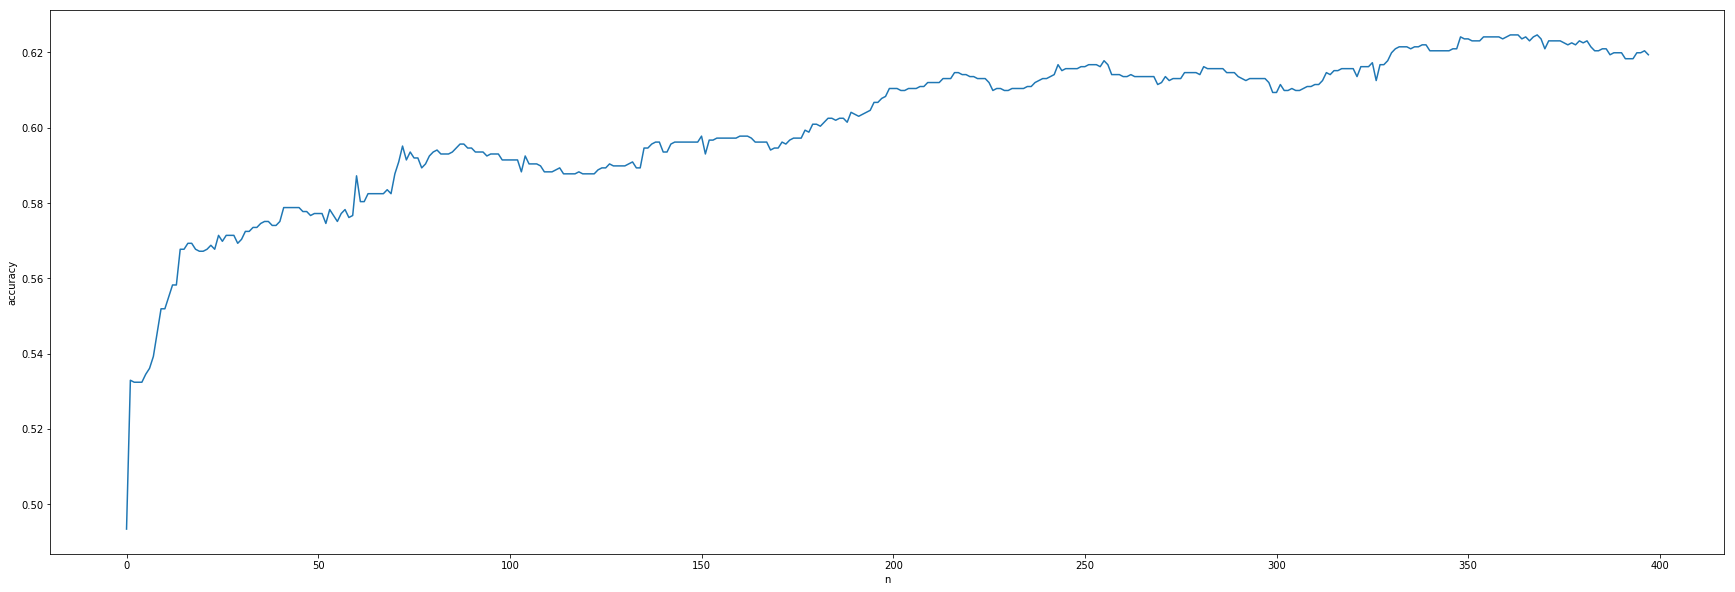

In [73]:
# Testando algumas possibilidades para max_leaf_nodes
accuracy3 = []
for i in range(2, 400):
    classifier3 = DecisionTreeClassifier(max_leaf_nodes=i, random_state=7)
    classifier3.fit(X_train3, y_train3)

    group_prediction3 = classifier3.predict(X_test3)
    
    ac = accuracy_score(y_true=y_test3, y_pred=group_prediction3)
    accuracy3.append(ac)
A3 = pd.DataFrame({'n': range(0, len(accuracy3)), 'accuracy': accuracy3})

n_max3 = A3[A3['accuracy'] == A3['accuracy'].max()]['n'].iloc[0]
print('Accuracy máxima em max_depth={}.'.format(n_max3))

# Gráfico do erro
plt.figure(figsize=(30, 10))
sns.lineplot(x='n', y='accuracy', data=A3)
plt.show()

In [74]:
classifier3 = DecisionTreeClassifier(max_leaf_nodes=n_max3, random_state=7)
classifier3.fit(X_train3, y_train3)

group_prediction3 = classifier3.predict(X_test3)

In [76]:
accuracy_score(y_true=y_test3, y_pred=group_prediction3)

0.6236162361623616